In [5]:
import tensorflow as tf
import numpy as np
import cifar10
from utils import plot_images
from tfops import fc, flatten, inflate
from time import time
from os.path import exists

In [2]:
cifar10.maybe_download_and_extract()

data_train, _, _ = cifar10.load_training_data()
data_test, _, _ = cifar10.load_test_data()

- Download progress: 100.0%
Download finished. Extracting files.
Done.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [7]:
tf.reset_default_graph()

z_dim = 32

with tf.name_scope('inputs'):
    x_image = tf.placeholder(tf.float32, (None, 32, 32, 3), 'x')
    epsilon = tf.placeholder(tf.float32, (None, z_dim), 'epsilon')
    
with tf.name_scope('encoder'):
    x = flatten(x_image)
    z_mean = fc(x, z_dim, 'sigmoid', 'z_mean')
    z_std = fc(x, z_dim, 'sigmoid', 'z_std')
    with tf.name_scope('latent-space'):
        z = epsilon * z_std + z_mean
    
with tf.name_scope('decoder'):
    x_gen = fc(z, 3072, 'sigmoid', 'decode')
    x_gen = inflate(x_gen, (32, 32))
    
with tf.name_scope('optimize'):
    generation_loss = tf.reduce_mean((x_image - x_gen)**2, name='generation_loss')
    tf.summary.scalar('generation_loss', generation_loss)
    
    latent_loss = tf.reduce_mean(0.5 * tf.reduce_sum(z_mean ** 2 + z_std ** 2 - tf.log(z_std ** 2) - 1, axis=1))
    tf.summary.scalar('latent_loss', latent_loss)
    
    loss = generation_loss + 1e-3 * latent_loss
    tf.summary.scalar('loss', loss)
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
summ = tf.summary.merge_all()

In [24]:
def plot_reconstructions(session):
    img_idx = np.random.randint(0, len(data_test), 5)
    noise = np.random.randn(5, z_dim)
    
    original_img = data_test[img_idx, :, :, :]
    generated_img = session.run(x_gen, {x_image: original_img, epsilon: noise})
    
    plot_images(original_img)
    plot_images(generated_img)

In [14]:
def plot_generated_img(session):
    noise = np.random.randn(11, z_dim)

    generated_img = session.run(x_gen, {z: noise})
    
    plot_images(generated_img)

In [25]:
batch_size = 256
batches_per_epoch = int(len(data_train) / batch_size)

def optimize(epochs):
    start_time = time()
    
    with tf.Session() as sess:
        writer = tf.summary.FileWriter('output/VAE-CIFAR10')
        writer.add_graph(tf.get_default_graph())
        
        saver = tf.train.Saver()
        
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch = data_test[np.random.choice(len(data_test), batch_size, replace=False), :, :, :]
                noise = np.random.randn(batch_size, z_dim)
                sess.run(optimizer, {x_image: x_batch, epsilon: noise})
                
                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, {x_image: x_batch, epsilon: noise}), global_step=epoch * batches_per_epoch + batch)
                    
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_reconstructions(sess)
            
        saver.save(sess, 'checkpoints/VAE-CIFAR10/VAE-CIFAR10', write_meta_graph=False)
            
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

INFO:tensorflow:Restoring parameters from checkpoints/VAE-CIFAR10/VAE-CIFAR10
Reconstructions:


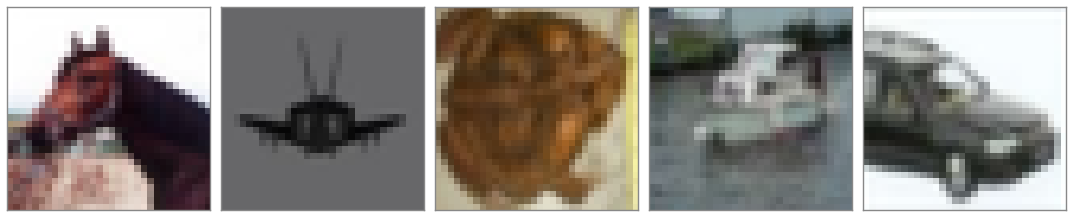

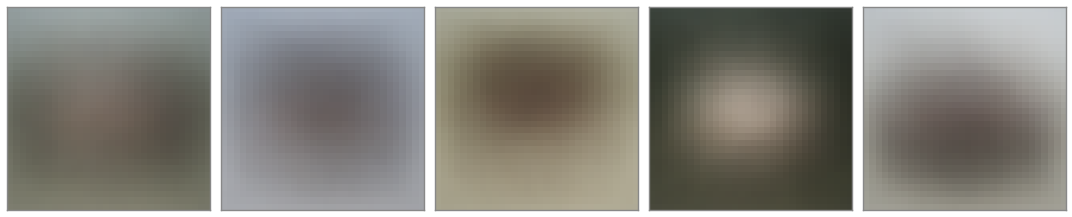

Generated:


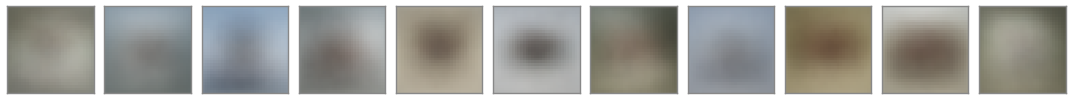

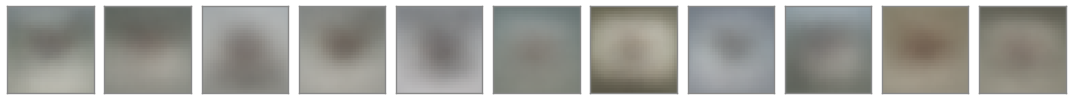

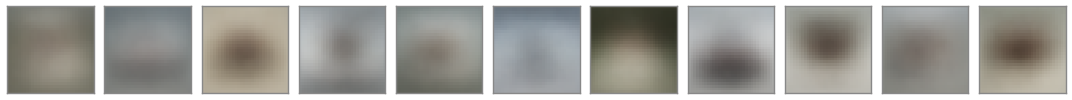

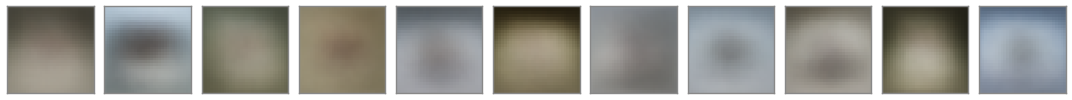

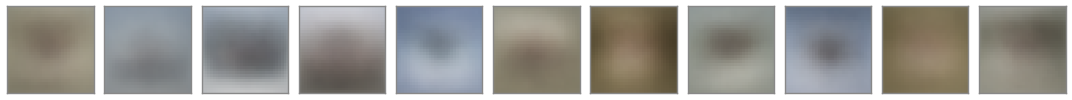

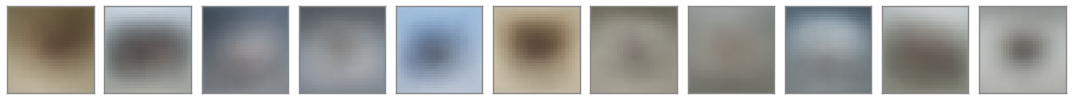

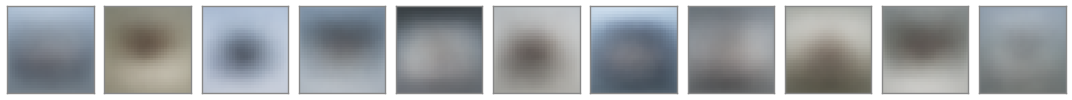

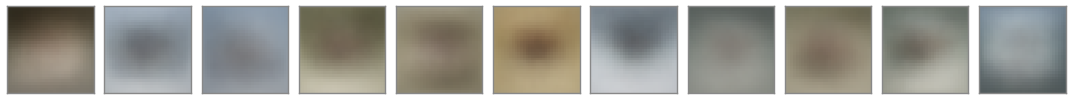

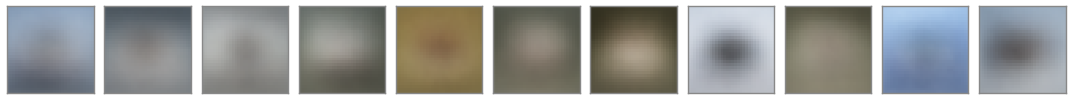

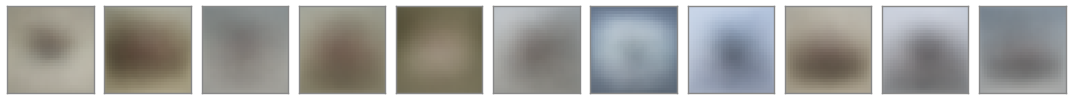

In [32]:
if exists('checkpoints/VAE-CIFAR10/VAE-CIFAR10.data-00000-of-00001'):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/VAE-CIFAR10/VAE-CIFAR10')
        
        print("Reconstructions:")
        plot_reconstructions(sess)
        
        print("Generated:")
        for _ in range(10):
            plot_generated_img(sess)
else:
    optimize(50)